In [1]:
import os
import numpy as np
import glob
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from pytorch_lightning import LightningModule
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split,DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.autograd import Variable
import pathlib


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
transformer = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

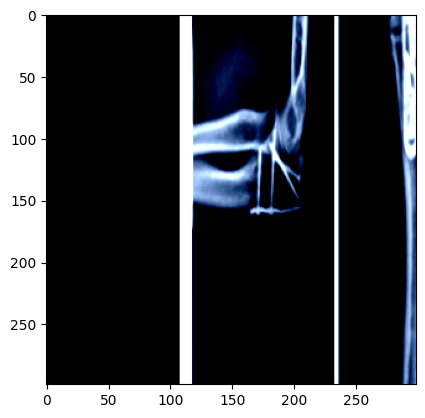

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
img=Image.open('/kaggle/input/bone-break-classifier-dataset/Avulsion fracture/Avulsion fracture/12891_2019_2585_Fig5_HTML.png').convert('RGB')
img=transformer(img)
plt.imshow(img.permute(1,2,0))

In [4]:
class_names=datasets.ImageFolder(root="/kaggle/input/bone-break-classifier-dataset",transform=None).classes

In [5]:
len(class_names)

12

In [6]:
dataset = datasets.ImageFolder(root="/kaggle/input/bone-break-classifier-dataset", transform=transformer)

# Split the dataset into training and test sets
X = [x[0] for x in dataset.imgs]  # List of file paths
y = [x[1] for x in dataset.imgs]  # List of labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Create new ImageFolder datasets for training and test sets
train_dataset = datasets.ImageFolder(root="/kaggle/input/bone-break-classifier-dataset", transform=transformer)
train_dataset.imgs = [(X_train[i], y_train[i]) for i in range(len(X_train))]

test_dataset = datasets.ImageFolder(root="/kaggle/input/bone-break-classifier-dataset", transform=transformer)
test_dataset.imgs = [(X_test[i], y_test[i]) for i in range(len(X_test))]


In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# class ConvNet(nn.Module):
#     def __init__(self,num_classes=12):
#         super(ConvNet,self).__init__()
#         #((w-f+2p)/s)+1
    
#         self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
#         self.bn1=nn.BatchNorm2d(num_features=64)
#         self.relu1=nn.ReLU()
#         self.pool=nn.MaxPool2d(kernel_size=2)
        
        
#         self.conv2=nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1)
#         self.relu2=nn.ReLU()
        
#         self.conv3=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1)
#         self.relu3=nn.ReLU()
#         self.pool3=nn.MaxPool2d(kernel_size=2)
        
        
#         self.conv4=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
#         self.relu4=nn.ReLU()
#         #self.pool4=nn.MaxPool2d(kernel_size=2)
        
#         self.conv5=nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1)
#         self.bn5=nn.BatchNorm2d(num_features=32)
#         self.relu5=nn.ReLU()
#         #shape=(128,32,75,75)
        
        
#         self.fc=nn.Linear(in_features=32*56*56,out_features=num_classes)
        
        
#     def forward(self,input):
#         output=self.conv1(input)
#         output=self.bn1(output)
#         output=self.relu1(output)
        
#         output=self.pool(output)
        
#         output=self.conv2(output)
#         output=self.relu2(output)
        
#         output=self.conv3(output)
#         output=self.relu3(output)
#         output=self.pool3(output)
        
#         output=self.conv4(output)
#         output=self.relu4(output)
#         #output=self.pool4(output)
        
#         output=self.conv5(output)
#         output=self.bn5(output)
#         output=self.relu5(output)
        
        
#         output=output.view(-1,32*56*56)
        
#         output=self.fc(output)
        
#         return output

In [9]:
from torchvision import models
model=models.inception_v3(pretrained=True)
num_classes=len(class_names)
model.fc=nn.Linear(model.fc.in_features,num_classes)
model.to('cuda')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 239MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [10]:
print("Is CUDA enabled?",torch.cuda.is_available())

Is CUDA enabled? True


In [11]:
optimiser=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
num_epochs=500

In [ ]:
best_accuracy=0.0

for epoch in range (num_epochs):
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i ,(images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimiser.zero_grad()
        outputs,x=model(images)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimiser.step()
        
        train_loss+=loss.cpu().data*images.size(0)
        _, prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
    train_accuracy=train_accuracy/len(train_loader.dataset)
    train_loss=train_loss/len(train_loader.dataset)
    
    
    model.eval()
    test_accuracy=0.0
    total_predictions=0
    for i ,(images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
            
        outputs=model(images)
        _, prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        total_predictions += labels.size(0)
        
    test_accuracy=test_accuracy/total_predictions
    
    if epoch%10==0:
        print('Epoch: '+str(epoch)+' Train loss: '+str(train_loss)+' Train accuracy '+str(train_accuracy)+' Test accuracy '+str(test_accuracy))
    
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy



/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 0 Train loss: tensor(2.4433) Train accuracy 0.1542111506524318 Test accuracy 0.16488730723606168
Epoch: 10 Train loss: tensor(2.2429) Train accuracy 0.21530249110320285 Test accuracy 0.24495848161328587
Epoch: 20 Train loss: tensor(2.0563) Train accuracy 0.3054567022538553 Test accuracy 0.27876631079478054
Epoch: 30 Train loss: tensor(1.9618) Train accuracy 0.337485172004745 Test accuracy 0.34104389086595494
Epoch: 40 Train loss: tensor(1.8368) Train accuracy 0.38730723606168443 Test accuracy 0.3529062870699881
Epoch: 50 Train loss: tensor(1.7139) Train accuracy 0.41162514827995256 Test accuracy 0.3819691577698695
Epoch: 60 Train loss: tensor(1.6218) Train accuracy 0.44958481613285883 Test accuracy 0.4531435349940688
Epoch: 70 Train loss: tensor(1.5096) Train accuracy 0.48991696322657174 Test accuracy 0.50355871886121
Epoch: 80 Train loss: tensor(1.4410) Train accuracy 0.5177935943060499 Test accuracy 0.466785290628707
Epoch: 90 Train loss: tensor(1.3184) Train accuracy 0.551008

In [1]:
best_accuracy

NameError: name 'best_accuracy' is not defined